# Financial Fraud Detection using Decision Tree Machine Learning Models

In this notebook, we will showcase the use of decision tree ML models to perform financial fraud detection.

<br/>

### Source Data
PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This [synthetic dataset](https://www.kaggle.com/ntnu-testimon/paysim1) is scaled down 1/4 of the original dataset and it is created just for Kaggle.  To load the dataset yourself, please download it to your local machine from Kaggle and then import the data via **Import Data**: [Azure](https://docs.azuredatabricks.net/user-guide/importing-data.html#import-data) | [AWS](https://docs.databricks.com/user-guide/importing-data.html#import-data).

<br/>

### Dictionary
This is the column definition of the referenced sythentic dataset.

| Column Name | Description |
| ----------- | ----------- | 
| step | maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).|
| type | CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER. |
| amount |  amount of the transaction in local currency. |
| nameOrig | customer who started the transaction |
| oldbalanceOrg | initial balance before the transaction |
| newbalanceOrig | new balance after the transaction |
| nameDest | customer who is the recipient of the transaction |
| oldbalanceDest | initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants). |
| newbalanceDest | new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants). |
<br/>


In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
# Configure MLflow Experiment
mlflow_experiment_id = 866112

# Including MLflow
import mlflow
import mlflow.spark

import os
print("MLflow Version: %s" % mlflow.__version__)

MLflow Version: 2.11.3


In [0]:
# Create df DataFrame which contains our simulated financial fraud detection dataset
df = spark.sql("select step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest from sim_fin_fraud_detection")

In [0]:
# Review the schema of your data 
df.printSchema()

root
 |-- step: long (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)



### Calculate Differences between Originating and Destination Balanaces
With the following PySpark DataFrame query, we will calculate the following columns:

| New Column | Definition |
| ---------- | ---------- |
| orgDiff | Difference between the originating balance |
| destDiff | Difference between the destination balance |


In [0]:
# Calculate the differences between originating and destination balances
df = df.withColumn("orgDiff", df.newbalanceOrig - df.oldbalanceOrg).withColumn("destDiff", df.newbalanceDest - df.oldbalanceDest)

# Create temporary view
df.createOrReplaceTempView("financials")

### Let's review the data and ask some simple questions

In [0]:
# Review the new table (including the origination and destiation differences)
display(df)

step type amount nameOrig oldbalanceOrg newbalanceOrig nameDest oldbalanceDest newbalanceDest orgDiff destDiff 1 PAYMENT 9839.64 C1231006815 170136.0 160296.36 M1979787155 0.0 0.0 -9839.640000000014 0.0 1 PAYMENT 1864.28 C1666544295 21249.0 19384.72 M2044282225 0.0 0.0 -1864.2799999999988 0.0 1 TRANSFER 181.0 C1305486145 181.0 0.0 C553264065 0.0 0.0 -181.0 0.0 1 CASH_OUT 181.0 C840083671 181.0 0.0 C38997010 21182.0 0.0 -181.0 -21182.0 1 PAYMENT 11668.14 C2048537720 41554.0 29885.86 M1230701703 0.0 0.0 -11668.14 0.0 1 PAYMENT 7817.71 C90045638 53860.0 46042.29 M573487274 0.0 0.0 -7817.709999999999 0.0 1 PAYMENT 7107.77 C154988899 183195.0 176087.23 M408069119 0.0 0.0 -7107.7699999999895 0.0 1 PAYMENT 7861.64 C1912850431 176087.23 168225.59 M633326333 0.0 0.0 -7861.640000000014 0.0 1 PAYMENT 4024.36 C1265012928 2671.0 0.0 M1176932104 0.0 0.0 -2671.0 0.0 1 DEBIT 5337.77 C712410124 41720.0 36382.23 C195600860 41898.0 40348.79 -5337.769999999997 -1549.2099999999991 1 DEBIT 9644.94 C1900366749 4465.0 0.0 C997608398 10845.0 157982.12 -4465.0 147137.12 1 PAYMENT 3099.97 C249177573 20771.0 17671.03 M2096539129 0.0 0.0 -3099.970000000001 0.0 1 PAYMENT 2560.74 C1648232591 5070.0 2509.26 M972865270 0.0 0.0 -2560.74 0.0 1 PAYMENT 11633.76 C1716932897 10127.0 0.0 M801569151 0.0 0.0 -10127.0 0.0 1 PAYMENT 4098.78 C1026483832 503264.0 499165.22 M1635378213 0.0 0.0 -4098.780000000028 0.0 1 CASH_OUT 229133.94 C905080434 15325.0 0.0 C476402209 5083.0 51513.44 -15325.0 46430.44 1 PAYMENT 1563.82 C761750706 450.0 0.0 M1731217984 0.0 0.0 -450.0 0.0 1 PAYMENT 1157.86 C1237762639 21156.0 19998.14 M1877062907 0.0 0.0 -1157.8600000000006 0.0 1 PAYMENT 671.64 C2033524545 15123.0 14451.36 M473053293 0.0 0.0 -671.6399999999994 0.0 1 TRANSFER 215310.3 C1670993182 705.0 0.0 C1100439041 22425.0 0.0 -705.0 -22425.0 1 PAYMENT 1373.43 C20804602 13854.0 12480.57 M1344519051 0.0 0.0 -1373.4300000000003 0.0 1 DEBIT 9302.79 C1566511282 11299.0 1996.21 C1973538135 29832.0 16896.7 -9302.79 -12935.3 1 DEBIT 1065.41 C1959239586 1817.0 751.59 C515132998 10330.0 0.0 -1065.4099999999999 -10330.0 1 PAYMENT 3876.41 C504336483 67852.0 63975.59 M1404932042 0.0 0.0 -3876.4100000000035 0.0 1 TRANSFER 311685.89 C1984094095 10835.0 0.0 C932583850 6267.0 2719172.89 -10835.0 2712905.89 1 PAYMENT 6061.13 C1043358826 443.0 0.0 M1558079303 0.0 0.0 -443.0 0.0 1 PAYMENT 9478.39 C1671590089 116494.0 107015.61 M58488213 0.0 0.0 -9478.39 0.0 1 PAYMENT 8009.09 C1053967012 10968.0 2958.91 M295304806 0.0 0.0 -8009.09 0.0 1 PAYMENT 8901.99 C1632497828 2958.91 0.0 M33419717 0.0 0.0 -2958.91 0.0 1 PAYMENT 9920.52 C764826684 0.0 0.0 M1940055334 0.0 0.0 0.0 0.0 1 PAYMENT 3448.92 C2103763750 0.0 0.0 M335107734 0.0 0.0 0.0 0.0 1 PAYMENT 4206.84 C215078753 0.0 0.0 M1757317128 0.0 0.0 0.0 0.0 1 PAYMENT 5885.56 C840514538 0.0 0.0 M1804441305 0.0 0.0 0.0 0.0 1 PAYMENT 5307.88 C1768242710 0.0 0.0 M1971783162 0.0 0.0 0.0 0.0 1 PAYMENT 5031.22 C247113419 0.0 0.0 M151442075 0.0 0.0 0.0 0.0 1 PAYMENT 24213.67 C1238616099 0.0 0.0 M70695990 0.0 0.0 0.0 0.0 1 PAYMENT 8603.42 C1608633989 253.0 0.0 M1615617512 0.0 0.0 -253.0 0.0 1 PAYMENT 2791.42 C923341586 300481.0 297689.58 M107994825 0.0 0.0 -2791.4199999999837 0.0 1 PAYMENT 7413.54 C1470868839 297689.58 290276.03 M1426725223 0.0 0.0 -7413.549999999988 0.0 1 PAYMENT 3295.19 C711197015 233633.0 230337.81 M1384454980 0.0 0.0 -3295.1900000000023 0.0 1 PAYMENT 1684.81 C1481594086 297.0 0.0 M1569435561 0.0 0.0 -297.0 0.0 1 DEBIT 5758.59 C1466917878 32604.0 26845.41 C1297685781 209699.0 16997.22 -5758.59 -192701.78 1 CASH_OUT 110414.71 C768216420 26845.41 0.0 C1509514333 288800.0 2415.16 -26845.41 -286384.84 1 PAYMENT 7823.46 C260084831 998.0 0.0 M267814113 0.0 0.0 -998.0 0.0 1 PAYMENT 5086.48 C598357562 0.0 0.0 M1593224710 0.0 0.0 0.0 0.0 1 PAYMENT 5281.48 C1440738283 152019.0 146737.52 M1849015357 0.0 0.0 -5281.4800000000105 0.0 1 PAYMENT 13875.98 C484199463 15818.0 1942.02 M2008106788 0.0 0.0 -13875.98 0.0 1 CASH_OUT 56953.9 C1570470538 1942.02 0.0 C824009085 702

#### What are the type of transactions?

In [0]:
%sql
-- Organize by Type
select type, count(1) from financials group by type

type count(1) TRANSFER 532909 CASH_IN 1399284 CASH_OUT 2237500 PAYMENT 2151495 DEBIT 41432

#### How much money are we talking about (synthetically)?

In [0]:
%sql
select type, sum(amount) from financials group by type

type sum(amount) TRANSFER 4.8529198726316833E11 CASH_IN 2.3636739191246027E11 CASH_OUT 3.944129952244888E11 PAYMENT 2.8093371138370014E10 DEBIT 2.271992212799996E8


## Rules-based Model: Create a set of rules to identify fraud based on known cases

The following `where` clause are a set of rules to identify know fraud-based cases using SQL; i.e. rules-based model.
* Often, financial fraud analytics start with with clauses like the `where` clause below
* Note, in reality, rules are often much larger and more complicated 

In [0]:
from pyspark.sql import functions as F

# Rules to Identify Known Fraud-based
df = df.withColumn("label", 
                   F.when(
                     (
                       (df.oldbalanceOrg <= 56900) & (df.type == "TRANSFER") & (df.newbalanceDest <= 105)) | 
                       (
                         (df.oldbalanceOrg > 56900) & (df.newbalanceOrig <= 12)) | 
                           (
                             (df.oldbalanceOrg > 56900) & (df.newbalanceOrig > 12) & (df.amount > 1160000)
                           ), 1
                   ).otherwise(0))

# Calculate proportions
fraud_cases = df.filter(df.label == 1).count()
total_cases = df.count()
fraud_pct = 1.*fraud_cases/total_cases

# Provide quick statistics
print("Based on these rules, we have flagged %s (%s) fraud cases out of a total of %s cases." % (fraud_cases, fraud_pct, total_cases))

# Create temporary view to review data
df.createOrReplaceTempView("financials_labeled")

Based on these rules, we have flagged 255640 (0.04017841706718302) fraud cases out of a total of 6362620 cases.


### How much fraud are we talking about?
Based on the existing rules, while 4% of the transactions are fraudulent, it takes into account of the 11% of the total amount.   

In [0]:
%sql
select label, count(1) as `Transactions`, sum(amount) as `Total Amount` from financials_labeled group by label

label Transactions Total Amount 1 255640 1.2932429667648047E11 0 6106980 1.0150686480832968E12

#### Top Origination / Destination Difference Pairs (>$1M TotalDestDiff)
Each bar represents a pair of entities performing a transaction

In [0]:
%sql
-- where sum(destDiff) >= 10000000.00
select nameOrig, nameDest, label, TotalOrgDiff, TotalDestDiff
  from (
     select nameOrig, nameDest, label, sum(OrgDiff) as TotalOrgDiff, sum(destDiff) as TotalDestDiff 
       from financials_labeled 
      group by nameOrig, nameDest, label 
     ) a
 where TotalDestDiff >= 1000000
 limit 100

nameOrig nameDest label TotalOrgDiff TotalDestDiff C439479548 C894315519 0 0.0 1118054.35 C1605848277 C1902115969 0 0.0 4242955.619999999 C921022316 C1763570403 0 0.0 1078870.9500000002 C1174970343 C1204620584 0 0.0 2102185.0799999996 C1019242580 C1662325188 0 -326.0 1094064.21 C1579384150 C296941183 0 -8182.0 1142032.67 C1146673748 C424648779 0 0.0 1281104.22 C456026573 C550658855 0 0.0 1240552.33 C2136817499 C212161362 0 0.0 3635260.7 C1615184014 C2133339718 0 0.0 1022810.6199999999 C374968098 C2113196809 0 0.0 1495042.2200000002 C1409108645 C1286029445 0 0.0 1379501.51 C1201085120 C278732228 0 -18339.68 2769654.01 C500986727 C392723053 0 0.0 1099494.48 C819577285 C417662216 0 -52175.0 2436799.7700000005 C1912851400 C117406596 0 -1027.0 1905468.2600000002 C1657907778 C466411183 0 -567.0 1137053.25 C395253666 C1470024650 0 0.0 3582572.1099999994 C751907164 C1944036258 1 -66145.0 4395599.25 C1107187431 C1918232364 0 0.0 1670489.4700000002 C232167927 C949597272 0 -30118.0 2443650.63 C1684152624 C1244821447 0 177917.9299999997 1689592.2800000003 C1938191953 C1720946336 0 -28454.0 2047211.2100000002 C681869707 C1779715197 0 0.0 1316290.98 C1472342353 C1090594488 0 0.0 1378876.0000000005 C1224911431 C23867413 0 -882.0 1874780.25 C590072723 C1567850046 0 -25769.0 3865022.26 C1758329003 C159310976 0 -9219.0 1288244.48 C1947918479 C1517245954 0 0.0 1974726.4100000001 C931423237 C878374257 0 0.0 1739980.3299999982 C687136209 C1284984569 0 -24122.0 1098191.27 C1700094399 C1146876728 0 0.0 1118184.83 C338233065 C460965692 0 0.0 1766009.4699999997 C1444472205 C305270141 0 0.0 1077535.65 C729358031 C486388931 0 0.0 1001107.1600000001 C518076407 C2055300077 0 -1373.0 1724866.5299999998 C895990508 C948354603 0 0.0 1048621.2300000002 C1606408034 C624420957 0 -687.0 2453766.65 C1086444193 C1832580921 0 0.0 1460649.000000001 C1302240948 C840935761 0 0.0 2315266.1999999993 C1117581192 C323893307 0 0.0 1533650.6900000004 C1457539209 C1879948586 1 -2460110.25 2460110.25 C594699712 C1604860231 1 -100554.0 1109622.25 C1077546102 C2116963092 0 -8598.0 1593585.86 C739004722 C1512980870 0 -5322.0 1205186.2 C1028028106 C1665826521 0 -27443.0 1349077.12 C1626241158 C1036941503 0 0.0 1627611.8599999994 C613540987 C516558590 0 -42804.0 1482112.97 C2138400576 C938182311 0 0.0 1071440.4900000002 C828618384 C776555139 0 0.0 1425982.42 C1150601293 C342226083 0 -20444.0 1199931.99 C112220490 C632116376 1 -174118.12 1931530.62 C795527830 C1327173282 0 0.0 1138385.11 C460442437 C208376827 0 0.0 1110752.71 C817749408 C897200846 0 0.0 1988833.2999999993 C116451799 C1167831782 0 -520.0 1027891.3099999999 C1153016106 C1631554045 0 0.0 1558404.57 C1410443453 C35885890 0 -184.0 1188411.84 C1222734343 C122631871 0 0.0 1415583.3500000006 C180917297 C442042163 1 -189986.89 1285086.79 C129776482 C1273659924 0 0.0 1283910.9300000002 C1458491877 C83581040 0 0.0 1208016.6900000002 C902036631 C1940691119 0 0.0 2050271.6800000006 C962107524 C1642666788 1 -69386.0 2071689.88 C1739724631 C18703336 0 -50907.0 1972785.41 C966421293 C494058921 0 0.0 1055808.6199999996 C571338099 C770304828 0 -12433.0 1229763.0299999998 C1884228868 C449775363 0 -11586.0 1689750.290000001 C999052586 C1117035335 0 0.0 1054952.3099999987 C1404370154 C1224420756 0 -51482.0 1224682.1 C1313904692 C240079765 0 0.0 1420290.9 C1533325096 C13111744 0 0.0 1379138.7900000003 C1621651157 C993777150 0 0.0 1225746.4400000013 C1223123248 C417839879 0 0.0 1059063.83 C173444736 C1711066407 0 -35553.0 1160324.27 C1401715668 C393716877 0 -36475.0 1153263.07 C1774363786 C605867389 0 0.0 1621994.43 C249997861 C1742381817 0 0.0 1532334.6999999997 C956104837 C1102086696 0 -50735.0 1055761.25 C1064524534 C1086383182 0 -618.0 1251353.98 C2021755287 C1471251550 0 -21058.0 1043383.76 C1601655156 C1651384621 0 -25755.0 1234155.54 C1067784628 C1555779554 1 -193178.66 1219359.1199999992 C1241768110 C1348373832 0 0.0 1287877.0799999996 C665925934 C1930402229 0 0.0 1039318.6600000001 C1430611924 C794651201 0 0.0 1284122.04 C2144914

### What type of transactions are associated with fraud?
Reviewing the rules-based model, it appears that most fraudulent transactions are in the category of `Transfer` and `Cash_Out`.

In [0]:
%sql
select type, label, count(1) as `Transactions` from financials_labeled group by type, label

type label Transactions PAYMENT 0 2150909 CASH_OUT 0 2052790 DEBIT 1 31 TRANSFER 1 70248 CASH_OUT 1 184710 PAYMENT 1 586 DEBIT 0 41401 CASH_IN 0 1399219 TRANSFER 0 462661 CASH_IN 1 65

# Rules vs. ML model
Instead of creating specific rules that will change over time, can we be more precise and go to production faster by creating a ML model?


## Decision Trees

[Decision trees](http://en.wikipedia.org/wiki/Decision_tree_learning) and their ensembles are popular methods for the machine learning tasks of classification and regression. Decision trees are widely used since they are easy to interpret, handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions. Tree ensemble algorithms such as random forests and boosting are among the top performers for classification and regression tasks.  

Because of these facets, decision trees often perform well on top of rules-based models and are often a good starting point for fraud detection.

![](http://cdn.iopscience.com/images/1749-4699/5/1/015004/Full/csd422281fig1.jpg)

Source: [The Wise Old Tree](https://pallav-routh.netlify.com/post/the-wise-old-tree/)

### Create training and test datasets
To build and validate our generalized fraud ML model, we will initially split the data using `randomSplit` to create our training and test datasets.

In [0]:
# Initially split our dataset between training and test datasets
(train, test) = df.randomSplit([0.8, 0.2], seed=12345)

# Cache the training and test datasets
train.cache()
test.cache()

# Print out dataset counts
print("Total rows: %s, Training rows: %s, Test rows: %s" % (df.count(), train.count(), test.count()))

Total rows: 6362620, Training rows: 5090429, Test rows: 1272191


### Create ML Pipeline
When creating an ML model, there are typically a set of repeated steps (e.g. `StringIndexer`, `VectorAssembler`, etc.).  By creating a ML pipeline, we can reuse this pipeline (and all of its steps) to retrain on a new and/or updated dataset.

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier

# Encodes a string column of labels to a column of label indices
indexer = StringIndexer(inputCol = "type", outputCol = "typeIndexed")

# VectorAssembler is a transformer that combines a given list of columns into a single vector column
va = VectorAssembler(inputCols = ["typeIndexed", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "orgDiff", "destDiff"], outputCol = "features")

# Using the DecisionTree classifier model
dt = DecisionTreeClassifier(labelCol = "label", featuresCol = "features", seed = 54321, maxDepth = 5)

# Create our pipeline stages
pipeline = Pipeline(stages=[indexer, va, dt])

In [0]:
# View the Decision Tree model (prior to CrossValidator)
dt_model = pipeline.fit(train)
display(dt_model.stages[-1])

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

treeNode {"index":13,"featureType":"continuous","prediction":null,"threshold":-58583.08,"categories":null,"feature":6,"overflow":false} {"index":1,"featureType":"continuous","prediction":null,"threshold":10.515,"categories":null,"feature":3,"overflow":false} {"index":0,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":7,"featureType":"continuous","prediction":null,"threshold":7676644.48,"categories":null,"feature":2,"overflow":false} {"index":3,"featureType":"continuous","prediction":null,"threshold":736800.775,"categories":null,"feature":1,"overflow":false} {"index":2,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":5,"featureType":"continuous","prediction":null,"threshold":2083377.42,"categories":null,"feature":2,"overflow":false} {"index":4,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":6,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":11,"featureType":"continuous","prediction":null,"threshold":133.775,"categories":null,"feature":5,"overflow":false} {"index":9,"featureType":"categorical","prediction":null,"threshold":null,"categories":[1.0],"feature":0,"overflow":false} {"index":8,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":10,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":12,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":21,"featureType":"continuous","prediction":null,"threshold":-34262.515,"categories":null,"feature":6,"overflow":false} {"index":19,"featureType":"continuous","prediction":null,"threshold":49816.5,"categories":null,"feature":2,"overflow":false} {"index":17,"featureType":"continuous","prediction":null,"threshold":133.775,"categories":null,"feature":5,"overflow":false} {"index":15,"featureType":"categorical","prediction":null,"threshold":null,"categories":[0.0,1.0],"feature":0,"overflow":false} {"index":14,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":16,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":18,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":20,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":23,"featureType":"categorical","prediction":null,"threshold":null,"categories":[0.0,1.0,2.0,4.0],"feature":0,"overflow":false} {"index":22,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":27,"featureType":"continuous","prediction":null,"threshold":133.775,"categories":null,"feature":5,"overflow":false} {"index":25,"featureType":"continuous","prediction":null,"threshold":60765.5,"categories":null,"feature":2,"overflow":false} {"index":24,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":26,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":28,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false}

### Use BinaryClassificationEvaluator
Determine the accuracy of the model by reviewing the `areaUnderPR` and `areaUnderROC`

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Use BinaryClassificationEvaluator to evaluate our model
evaluatorPR = BinaryClassificationEvaluator(labelCol = "label", rawPredictionCol = "prediction", metricName = "areaUnderPR")
evaluatorAUC = BinaryClassificationEvaluator(labelCol = "label", rawPredictionCol = "prediction", metricName = "areaUnderROC")

### Setup CrossValidation
To try out different parameters to potentially improve our model, we will use `CrossValidator` in conjunction with the `ParamGridBuilder` to automate trying out different parameters.

Note, we are using `evaluatorPR` as our `evaluator` as the Precision-Recall curve is often better for an unbalanced distribution.

In [0]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Build the grid of different parameters
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [10, 20, 30]) \
    .build()

# Build out the cross validation
crossval = CrossValidator(estimator = dt,
                          estimatorParamMaps = paramGrid,
                          evaluator = evaluatorPR,
                          numFolds = 3)  

pipelineCV = Pipeline(stages=[indexer, va, crossval])

# Train the model using the pipeline, parameter grid, and preceding BinaryClassificationEvaluator
cvModel_u = pipelineCV.fit(train)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

### Review Results
Review the `areaUnderPR` (area under Precision Recall curve) and `areaUnderROC` (area under Receiver operating characteristic) or `AUC` (area under curve) metrics.

In [0]:
# Build the best model (training and test datasets)
train_pred = cvModel_u.transform(train)
test_pred = cvModel_u.transform(test)

# Evaluate the model on training datasets
pr_train = evaluatorPR.evaluate(train_pred)
auc_train = evaluatorAUC.evaluate(train_pred)

# Evaluate the model on test datasets
pr_test = evaluatorPR.evaluate(test_pred)
auc_test = evaluatorAUC.evaluate(test_pred)

# Print out the PR and AUC values
print("PR train:", pr_train)
print("AUC train:", auc_train)
print("PR test:", pr_test)
print("AUC test:", auc_test)

PR train: 0.9441348041064112
AUC train: 0.9986172174735871
PR test: 0.9459494408343028
AUC test: 0.9986369139972286


### Confusion Matrix Code-base
Subsequent cells will be using the following code to plot the confusion matrix.

In [0]:
# Create confusion matrix template
from pyspark.sql.functions import lit, expr, col, column

# Confusion matrix template
cmt = spark.createDataFrame([(1, 0), (0, 0), (1, 1), (0, 1)], ["label", "prediction"])
cmt.createOrReplaceTempView("cmt")

In [0]:
# Source code for plotting confusion matrix is based on `plot_confusion_matrix` 
# via https://runawayhorse001.github.io/LearningApacheSpark/classification.html#decision-tree-classification
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, title):
  # Clear Plot
  plt.gcf().clear()

  # Configure figure
  fig = plt.figure(1)
  
  # Configure plot
  classes = ['Fraud', 'No Fraud']
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  # Normalize and establish threshold
  normalize=False
  fmt = 'd'
  thresh = cm.max() / 2.

  # Iterate through the confusion matrix cells
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  # Final plot configurations
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label') 
  
  # Display images
  image = fig
  
  # Show plot
  #fig = plt.show()
  
  # Save plot
  fig.savefig("confusion-matrix.png")

  # Display Plot
  display(image)
  
  # Close Plot
  plt.close(fig)

In [0]:
# Create temporary view for test predictions
test_pred.createOrReplaceTempView("test_pred")

# Create test predictions confusion matrix
test_pred_cmdf = spark.sql("select a.label, a.prediction, coalesce(b.count, 0) as count from cmt a left outer join (select label, prediction, count(1) as count from test_pred group by label, prediction) b on b.label = a.label and b.prediction = a.prediction order by a.label desc, a.prediction desc")

# View confusion matrix
display(test_pred_cmdf)

label prediction count 1 1 51324 1 0 17 0 1 2924 0 0 1217926

### View Confusion Matrix
Let's use `matplotlib` and `pandas` to visualize our confusion matrix

In [0]:
# Convert to pandas
cm_pdf = test_pred_cmdf.toPandas()
print(cm_pdf)
# Create 1d numpy array of confusion matrix values
cm_1d = cm_pdf.iloc[:, 2].values
print(cm_1d)
# Create 2d numpy array of confusion matrix values
num_elements_cm_1d = len(cm_1d)
print(num_elements_cm_1d)
cm = np.reshape(cm_1d, (-1, 2))

# Print out the 2d array
print(cm)

   label  prediction    count
0      1           1    51324
1      1           0       17
2      0           1     2924
3      0           0  1217926
[  51324      17    2924 1217926]
4
[[  51324      17]
 [   2924 1217926]]


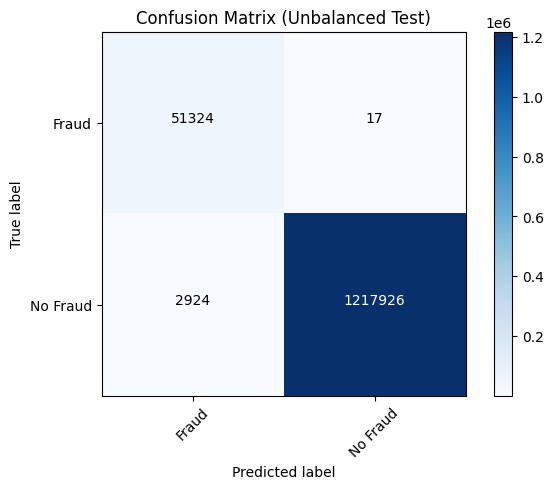

In [0]:
# Plot confusion matrix  
plot_confusion_matrix(cm, "Confusion Matrix (Unbalanced Test)")

In [0]:
# Log MLflow
with mlflow.start_run(experiment_id = mlflow_experiment_id) as run:
  # Log Parameters and metrics
  mlflow.log_param("balanced", "no")
  mlflow.log_metric("PR train", pr_train)
  mlflow.log_metric("AUC train", auc_train)
  mlflow.log_metric("PR test", pr_test)
  mlflow.log_metric("AUC test", auc_test)
  
  # Log model
  mlflow.spark.log_model(dt_model, "model")
  
  # Log Confusion matrix
  mlflow.log_artifact("confusion-matrix.png")

---------------------------------------------------------------------------
RestException                             Traceback (most recent call last)
File <command-3620472657705650>, line 2
      1 # Log MLflow
----> 2 with mlflow.start_run(experiment_id = mlflow_experiment_id) as run:
      3   # Log Parameters and metrics
      4   mlflow.log_param("balanced", "no")
      5   mlflow.log_metric("PR train", pr_train)

File /databricks/python/lib/python3.11/site-packages/mlflow/tracking/fluent.py:381, in start_run(run_id, experiment_id, run_name, nested, tags, description, log_system_metrics)
    377         user_specified_tags[MLFLOW_RUN_NAME] = run_name
    379     resolved_tags = context_registry.resolve_tags(user_specified_tags)
--> 381     active_run_obj = client.create_run(
    382         experiment_id=exp_id_for_run,
    383         tags=resolved_tags,
    384         run_name=run_name,
    385     )
    387 if log_system_metrics is None:
    388     # If `log_system_metrics` 


## Model with Balanced classes

Let's see if we can improve our decision tree model but balancing the Fraud vs. No Fraud cases. We will tune the model using the metrics `areaUnderROC` or (AUC)

In [0]:
# Reset the DataFrames for no fraud (`dfn`) and fraud (`dfy`)
dfn = train.filter(train.label == 0)
dfy = train.filter(train.label == 1)

# Calculate summary metrics
N = train.count()
y = dfy.count()
p = y/N

# Create a more balanced training dataset
train_b = dfn.sample(False, p, seed = 92285).union(dfy)

# Print out metrics
print("Total count: %s, Fraud cases count: %s, Proportion of fraud cases: %s" % (N, y, p))
print("Balanced training dataset count: %s" % train_b.count())

Total count: 5090429, Fraud cases count: 204299, Proportion of fraud cases: 0.040133945488680815
Balanced training dataset count: 399807


In [0]:
# Display our more balanced training dataset
display(train_b.groupBy("label").count())

label count 0 195508 1 204299

### Update ML pipeline
Because we had created the ML pipeline stages in the previous cells, we can re-use them to execute it against our balanced dataset.

Note, we are using `evaluatorAUC` as our `evaluator` as this is often better for a balanced distribution.

In [0]:
# Re-run the same ML pipeline (including parameters grid)
crossval_b = CrossValidator(estimator = dt,
                          estimatorParamMaps = paramGrid,
                          evaluator = evaluatorAUC,
                          numFolds = 3)  

pipelineCV_b = Pipeline(stages=[indexer, va, crossval_b])

# Train the model using the pipeline, parameter grid, and BinaryClassificationEvaluator using the `train_b` dataset
cvModel_b = pipelineCV_b.fit(train_b)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [0]:
# Build the best model (balanced training and full test datasets)
train_pred_b = cvModel_b.transform(train_b)
test_pred_b = cvModel_b.transform(test)

# Evaluate the model on the balanced training datasets
pr_train_b = evaluatorPR.evaluate(train_pred_b)
auc_train_b = evaluatorAUC.evaluate(train_pred_b)

# Evaluate the model on full test datasets
pr_test_b = evaluatorPR.evaluate(test_pred_b)
auc_test_b = evaluatorAUC.evaluate(test_pred_b)

# Print out the PR and AUC values
print("PR train:", pr_train_b)
print("AUC train:", auc_train_b)
print("PR test:", pr_test_b)
print("AUC test:", auc_test_b)

PR train: 0.9986367272204947
AUC train: 0.9972944199089786
PR test: 0.9962602521721218
AUC test: 0.9972781874549372


In [0]:
# Create temporary view for test predictions
test_pred_b.createOrReplaceTempView("test_pred_b")

# Create test predictions confusion matrix
test_pred_b_cmdf = spark.sql("select a.label, a.prediction, coalesce(b.count, 0) as count from cmt a left outer join (select label, prediction, count(1) as count from test_pred_b group by label, prediction) b on b.label = a.label and b.prediction = a.prediction order by a.label desc, a.prediction desc")

# View confusion matrix
display(test_pred_b_cmdf)

label prediction count 1 1 51064 1 0 277 0 1 59 0 0 1220791

In [0]:
# Convert to pandas
cm_b_pdf = test_pred_b_cmdf.toPandas()

# Create 1d numpy array of confusion matrix values
cm_b_1d = cm_b_pdf.iloc[:, 2].values

# Create 2d numpy array of confusion matrix vlaues
cm_b = np.reshape(cm_b_1d, (-1, 2))

# Print out the 2d array
print(cm_b)

[[  51064     277]
 [     59 1220791]]


## View Decision Tree Models
Visually compare the differences between the **unbalanced** and **balanced** decision tree models (basd on the `train` and `train_b` datasets respectively).

In [0]:
# Extract Feature Importance
#  Attribution: Feature Selection Using Feature Importance Score - Creating a PySpark Estimator
#               https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/
import pandas as pd

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [0]:
# View the Unbalanced Decision Tree model (prior to CrossValidator)
dt_model = pipeline.fit(train)
display(dt_model.stages[-1])

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

treeNode {"index":13,"featureType":"continuous","prediction":null,"threshold":-58583.08,"categories":null,"feature":6,"overflow":false} {"index":1,"featureType":"continuous","prediction":null,"threshold":10.515,"categories":null,"feature":3,"overflow":false} {"index":0,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":7,"featureType":"continuous","prediction":null,"threshold":7676644.48,"categories":null,"feature":2,"overflow":false} {"index":3,"featureType":"continuous","prediction":null,"threshold":736800.775,"categories":null,"feature":1,"overflow":false} {"index":2,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":5,"featureType":"continuous","prediction":null,"threshold":2083377.42,"categories":null,"feature":2,"overflow":false} {"index":4,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":6,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":11,"featureType":"continuous","prediction":null,"threshold":133.775,"categories":null,"feature":5,"overflow":false} {"index":9,"featureType":"categorical","prediction":null,"threshold":null,"categories":[1.0],"feature":0,"overflow":false} {"index":8,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":10,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":12,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":21,"featureType":"continuous","prediction":null,"threshold":-34262.515,"categories":null,"feature":6,"overflow":false} {"index":19,"featureType":"continuous","prediction":null,"threshold":49816.5,"categories":null,"feature":2,"overflow":false} {"index":17,"featureType":"continuous","prediction":null,"threshold":133.775,"categories":null,"feature":5,"overflow":false} {"index":15,"featureType":"categorical","prediction":null,"threshold":null,"categories":[0.0,1.0],"feature":0,"overflow":false} {"index":14,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":16,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":18,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":20,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":23,"featureType":"categorical","prediction":null,"threshold":null,"categories":[0.0,1.0,2.0,4.0],"feature":0,"overflow":false} {"index":22,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":27,"featureType":"continuous","prediction":null,"threshold":133.775,"categories":null,"feature":5,"overflow":false} {"index":25,"featureType":"continuous","prediction":null,"threshold":60765.5,"categories":null,"feature":2,"overflow":false} {"index":24,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":26,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":28,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false}

In [0]:
# Extract Feature Importance for the original unbalanced dt_model
ExtractFeatureImp(dt_model.stages[-1].featureImportances, train_pred, "features").head(10)

idx            name                                           vals     score
5    6         orgDiff                                            NaN  0.610418
2    3  newbalanceOrig                                            NaN  0.383127
4    5  newbalanceDest                                            NaN  0.004716
1    2   oldbalanceOrg                                            NaN  0.000863
7    0     typeIndexed  [CASH_OUT, PAYMENT, CASH_IN, TRANSFER, DEBIT]  0.000765
0    1          amount                                            NaN  0.000111
3    4  oldbalanceDest                                            NaN  0.000000
6    7        destDiff                                            NaN  0.000000

In [0]:
# View the Balanced Decision Tree model (prior to CrossValidator)
dt_model_b = pipeline.fit(train_b)
display(dt_model_b.stages[-1])

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

treeNode {"index":11,"featureType":"continuous","prediction":null,"threshold":-39641.015000000014,"categories":null,"feature":6,"overflow":false} {"index":7,"featureType":"continuous","prediction":null,"threshold":61.575,"categories":null,"feature":3,"overflow":false} {"index":5,"featureType":"continuous","prediction":null,"threshold":52600.5,"categories":null,"feature":2,"overflow":false} {"index":3,"featureType":"continuous","prediction":null,"threshold":139.005,"categories":null,"feature":5,"overflow":false} {"index":1,"featureType":"categorical","prediction":null,"threshold":null,"categories":[0.0,2.0],"feature":0,"overflow":false} {"index":0,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":2,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":4,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":6,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":9,"featureType":"continuous","prediction":null,"threshold":915662.95,"categories":null,"feature":1,"overflow":false} {"index":8,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":10,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":17,"featureType":"categorical","prediction":null,"threshold":null,"categories":[0.0,2.0,3.0,4.0],"feature":0,"overflow":false} {"index":13,"featureType":"continuous","prediction":null,"threshold":915662.95,"categories":null,"feature":1,"overflow":false} {"index":12,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":15,"featureType":"categorical","prediction":null,"threshold":null,"categories":[0.0],"feature":0,"overflow":false} {"index":14,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":16,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":23,"featureType":"continuous","prediction":null,"threshold":139.005,"categories":null,"feature":5,"overflow":false} {"index":19,"featureType":"continuous","prediction":null,"threshold":60400.5,"categories":null,"feature":2,"overflow":false} {"index":18,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":21,"featureType":"continuous","prediction":null,"threshold":42145.54,"categories":null,"feature":1,"overflow":false} {"index":20,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":22,"featureType":null,"prediction":1.0,"threshold":null,"categories":null,"feature":null,"overflow":false} {"index":24,"featureType":null,"prediction":0.0,"threshold":null,"categories":null,"feature":null,"overflow":false}

In [0]:
# Extract Feature Importance for the nbalanced dt_model
ExtractFeatureImp(dt_model_b.stages[-1].featureImportances, train_pred_b, "features").head(10)

idx            name                                           vals     score
5    6         orgDiff                                            NaN  0.895509
2    3  newbalanceOrig                                            NaN  0.057149
1    2   oldbalanceOrg                                            NaN  0.033981
4    5  newbalanceDest                                            NaN  0.009783
0    1          amount                                            NaN  0.002231
7    0     typeIndexed  [CASH_OUT, TRANSFER, PAYMENT, CASH_IN, DEBIT]  0.001347
3    4  oldbalanceDest                                            NaN  0.000000
6    7        destDiff                                            NaN  0.000000

## Comparing Confusion Matrices
Below we will compare the unbalanced and balanced decision tree ML model confusion matrices.

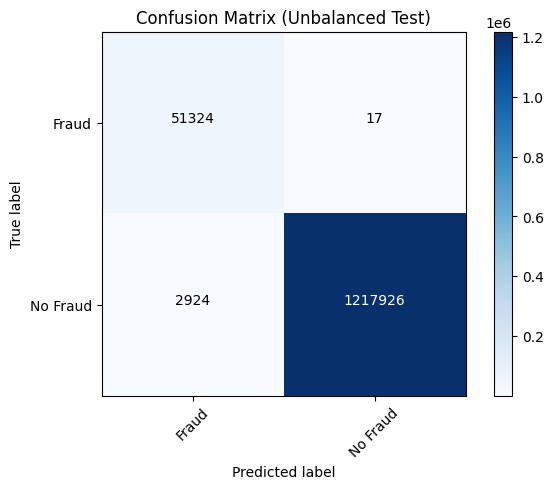

In [0]:
# Plot confusion matrix  
plot_confusion_matrix(cm, "Confusion Matrix (Unbalanced Test)")

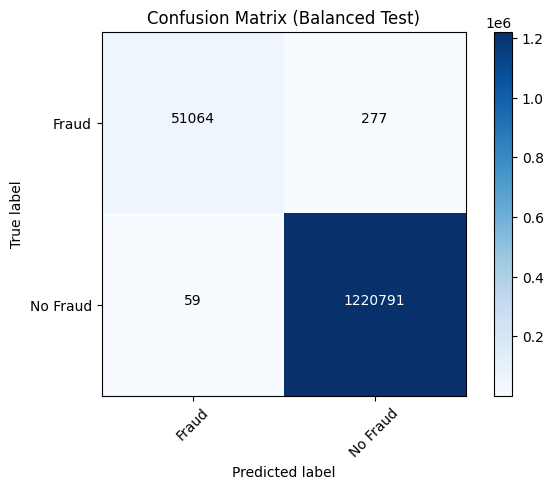

In [0]:
# Plot confusion matrix  
plot_confusion_matrix(cm_b, "Confusion Matrix (Balanced Test)")

In [0]:
# Log MLflow
with mlflow.start_run(experiment_id = mlflow_experiment_id) as run:
  # Log Parameters and metrics
  mlflow.log_param("balanced", "yes")
  mlflow.log_metric("PR train", pr_train_b)
  mlflow.log_metric("AUC train", auc_train_b)
  mlflow.log_metric("PR test", pr_test_b)
  mlflow.log_metric("AUC test", auc_test_b)
    
  # Log model
  mlflow.spark.log_model(dt_model_b, "model")
  
  # Log Confusion matrix
  mlflow.log_artifact("confusion-matrix.png")

### Observation

There is a significant difference for the `PR` and `AUC` values when comparing the unbalanced vs. balanced decision tree models.

| Metric/dataset | Unbalanced | Balanced |
| -------------- | ---------- | -------- |
| PR train | 0.9537894984523128 | 0.999629161563572 |
| AUC train | 0.998647996459481 | 0.9998071389056655 |
| PR test | 0.9539170535377599 | 0.9904709171789063 |
| AUC test | 0.9984378183482442 | 0.9997903902204509 |

You can also view this data directly within MLflow by comparing the unbalanced vs. balanced decision tree models as noted in the following animated GIF.

![](https://pages.databricks.com/rs/094-YMS-629/images/Fraud Analytics MLflow.gif)
